<h1><center>«Portfolio-Exam Part II» </center></h1>
<h2><center>MADS-EAI </center></h2>
<h3><center>Author: Tom Wüsten </center></h3>

## Introduction
Machine learning (ML) has emerged in recent years as a crucial enabling technology for the sciences and business. Today's ML algorithms are capable of achieving outstanding performance (at times even above the human level) on an expanding variety of complex tasks, thanks in large part to advancements in methodology, the availability of massive databases, and increased computer power. Leading this trend are deep learning models. These potent models have, however, traditionally been regarded as "black boxes" because of their layered non-linear structure because they don't explain how they create their predictions. The development of techniques for visualizing, elucidating, and analyzing deep learning models has lately drawn increased interest since in certain applications, such as the medical industry, such a lack of transparency may not be acceptable.<br>
In germany the main research in the field of Explaible AI is done at the Heinrich Hertz Institute in Berlin. This institute is contributing especially in the field of explainable AI for CNN. Later I'll use a library of them to explain CNN. The main idea about this project is to provide examples of methodologies in the field of explainable AI and show libraries which will be used to deomonstarte the methotolgies in code examples.[[1]](#100)

## Task
Black box systems have spread into a lot of the applications of today's world. Transparency and explainability are not essential requirements for machine learning models used in consumer electronics or online translation services as long as the systems' overall performance is sufficient. However, even if these technologies malfunction, such as when a person is not recognized by a cell phone camera or a translation service generates grammatically incorrect words, the results are generally not outstanding. Therefore, the standards for openness and trust in these kinds of AI systems are rather low. The situation is quite different in applications that are safety-critical. Here, the opaqueness of ML methods might be a restriction or even a disqualifier. It may not be a good idea to rely on a data-driven system whose thinking is opaque, particularly when doing so could put human life and health in jeopardy (as in autonomous driving, the medical field, or algorithmic trading). This lack of transparency is one of the reasons machine learning applications in industries like health are adopted with greater caution than consumer, e-commerce, or entertainment applications.[[1]](#100) <br>
The aim of the paper is to provide insights into different types of explanations of Deep Learning models. Thereby, it shall go from information about the learned representations to the identification the different prediction strategies and the evaluation of the overall behaviour of the model. For this purpose, methods are to be presented that are intended to solve these presented problems or make them better explainable. <br>

## Outline
* [Methods of Explainable AI](#1) <br>
    * [Explaining with Surrogates](#2) <br>
        * [Example of Surrogates with LIME](#3) <br>
        * [Example of Surrogates with SHAP](#4) <br>
    * [Explaining with Local Perturbations](#5) <br>
        * [Example of Local Perturbations with Adversarial Patches](#6) <br>
    * [Propagation-Based Approaches (Leveraging Structure)](#7) <br>
        * [Example of Propagation-Based Approaches (Leveraging Structure) with Zennit](#8) <br>
* [Evaluation and Challenges](#9) <br>
* [References](#10) <br>

## Methods of Explainable AI <a id='1'></a> 

This section provides an overview of several approaches to explainable AI, starting with methods that don't depend on specific models and instead use a straightforward surrogate function to explain the predictions. Next, we go through techniques for computing explanations by examining how the model responds to local perturbations (e.g., by utilizing gradient information or by optimization). We then provide extremely effective propagation-based explanation strategies that take use of the underlying structure of the model.
The purpose of this section is to highlight the most significant advancements in explanation methods rather than to provide a comprehensive assessment of explanation techniques. This section does not include all explainable AI methods, such as methods that look for influential instances. [[1]](#100)

### Explaining with Surrogates <a id='2'></a> 

It becomes easy to explain the predictions of simple classifiers, such as linear models or shallow decision trees, since they are inherently interpretable. On the other hand, complex classifiers like deep neural networks or recurrent models include several non-linear transformation layers, which makes it difficult to understand how they arrive at their predictions.
Using a simple, interpretable surrogate function to locally approximate complicated models' predictions is one method for explaining their results. Local Interpretable Model-agnostic Explanations are a common method that fits into this category (LIME).This approach samples in the vicinity of the relevant input, assesses the neural network at these locations, and attempts to fit the surrogate function so that it closely resembles the relevant function. LIME may even explain the choices made by a model that employs non-interpretable characteristics if the input domain of the surrogate function is human interpretable. LIME may be used with any classifier, regardless of its internals, such as the architecture or weights of a neural network classifier, because it is model agnostic. LIME's high computational complexity is one of its main drawbacks; for example, for cutting-edge models like GoogleNet, it takes several minutes to compute the explanation of a single prediction.
The SmoothGrad approach samples the area around the input to estimate the gradient, much to LIME, which creates a model for locally approximating the function of interest. Additionally, SmoothGrad needs access to the gradients but does not use the model's internal workings. It is also possible to think of it as a gradient-based explaining strategy. [[1]](#100)

##### Example of Surrogates with LIME  <a id='3'></a> 
This example should demonstrate how LIME can be used to understand the process of image classification. Therefore I use a pre-trained Resnet50 network to classify images. In this process I'll demonstrate how CNN are used in pytorch and show how model agnostic like LIME ca be used to get inside of a neural network.

In [1]:
# Load libaries
import torch
import torch.nn as nn
from torchvision import models 
import os

/Users/tom.wuesten/.pyenv/versions/3.9.9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


* Download pre-trained model from torchvision <br>

In [53]:
model = models.resnet50(pretrained=True)

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.


We see that the ResNet50 has over 25M parameters that need to be trained.

In [3]:
num_params=sum([p.numel() for p in model.parameters() if p.requires_grad])
print("Number of learnable paramters: "+"{:,}".format(num_params));

Number of learnable paramters: 25,557,032


Next step is importing libaries for image processing.

In [4]:
import cv2 as cv # python library for image processing
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

Our goal is it to detect a space shuttle with image recognation. Also we want to know which part is responsible for that decision.

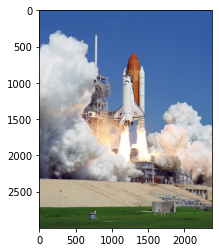

In [5]:
raw = cv.imread(f"data/space_shuttle.jpg")
raw = cv.cvtColor(raw, cv.COLOR_BGR2RGB) # convert colorspace
plt.imshow(raw)
plt.show()

Preprocesssing steps for the image recognation.

In [6]:
pil_transform = transforms.Compose([
    transforms.ToPILImage(), # Python Imaging Library
    transforms.Resize(299),
    transforms.CenterCrop(299),
    ])    

# adapt normalization from https://pytorch.org/vision/master/models.html
normalize_transform = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     

preprocess_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize_transform
    ])  

PIL image is in mode:  RGB with  3 channels and size: (299, 299)


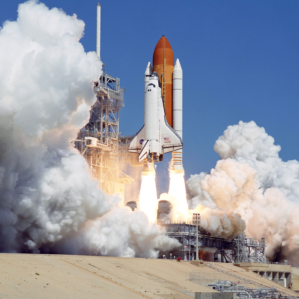

In [8]:
img = np.array(raw)
img = pil_transform(img)

print("PIL image is in mode: ", img.mode, "with ", len(img.split()), "channels and size:", img.size)
display(img)

torch.Size([3, 299, 299])
torch.Size([1, 3, 299, 299])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


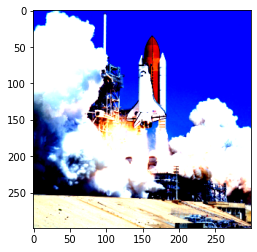

In [9]:
img = preprocess_transform(img)
print(img.size())
# unsqueeze to add a batch dimension
img = img.unsqueeze(0)
print(img.size())
plt.imshow(img[0].transpose(2,0).transpose(0,1))

The prediction of the model is a space shuttle. The confidence of 98% is very high. But also the second prediction of missile is actually really close to picture.

In [10]:
model.eval()
out=model(img)
_, index = torch.max(out, 1)
index
probabilities = torch.nn.functional.softmax(out[0], dim=0)
# Read thae categories
with open("data/imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
# Show top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())

space shuttle 0.98678058385849
missile 0.0071687051095068455
projectile 0.005879403091967106
warplane 3.3643034839769825e-05
wing 2.971148569486104e-05


In the next step we want to find out why the neural net predicts space shuttle. Therefore we want to find out which part of the photo was the reason for the prediction. We use LIME for that. The next step downloads LIME.

In [14]:
! pip install lime

In the next step the LIME Explainer will be used to find out which pixel are resonsponisble to the result.

In [15]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [16]:
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)
    
    out = model(batch)
    probs = torch.nn.functional.softmax(out, dim=1)
    return probs.detach().numpy()

In [17]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pil_transform(raw)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         num_samples=1000) # number of images that will be sent to classification function

100%|██████████| 1000/1000 [05:07<00:00,  3.25it/s]


The LIME predictor filtered all information out of the photo which are not important for the result. The final explainible photo shows only the space shuttle with their fuel tank. This image is particularly valuable when wrong decisions are made by the AI. Based on this, humans can understand which pixels tipped the scales for the prediction, so that they can make adjustments to the neural network or train particularly difficult images. Such information is particularly important for autonomous driving.

<class 'numpy.ndarray'>
(299, 299, 3)


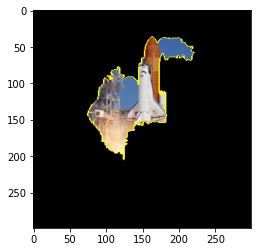

In [18]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
img_boundry1 = mark_boundaries(temp/255.0, mask)
print(type(img_boundry1))
print(img_boundry1.shape)
plt.imshow(img_boundry1)

#### Explaining with SHAP (SHapley Additive exPlanations) <a id='4'></a> 

Individual predictions can be explained using the SHAP (SHapley Additive exPlanations) approach developed by Lundberg and Lee in 2017. The game theoretically ideal Shapley values serve as the foundation for SHAP. By calculating the contribution of each characteristic to the prediction, SHAP seeks to explain the prediction of an instance x. Shapley values are calculated using the SHAP explanation approach using coalitional game theory. We can determine how to equally distribute the "payout" across the features using Shapley values, a strategy from coalitional game theory. [[3]](#102)


This example based on the California Housing Dataset from sklearn should provide an example how to use SHAP and get insights abouts the given prediction. This dataset is from 1990.

In [19]:
! pip install shap

The first step of the example is the import of the libaries.

In [ ]:
import shap
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

The next step is the data pre-processing.

In [ ]:
# California Housing Prices
dataset = fetch_california_housing(as_frame = True)
X = dataset['data']
y = dataset['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

For the Prediction a RandomForestRegressor will be used and trained.

In [20]:
# Prepares a default instance of the random forest regressor
model = RandomForestRegressor()
# Fits the model on the data
model.fit(X_train, y_train)

RandomForestRegressor()

For the interpretion of the results SHAP will be used. Our goal is to see which features has most influence in generell on prediction and which feature has for an specific prediction the most influence.

The first step is that we create a Shap explainer which takes the prediction of the Randomforest and test values. Then the explainer creates the shap Values.

In [21]:
# Fits the explainer
explainer = shap.Explainer(model.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)

Exact explainer: 4129it [25:56,  2.64it/s]                          


After the Explainer has created the shap values, which takes some time, you can show the influence of the parameters in the diagram. The MedInc, which describes the median income of the owners of the house, has the greatest influence on the prediction. Furthermore, the location also has a great influence on the prediction. Interestingly, the age of the house has almost no influence on the prediction.

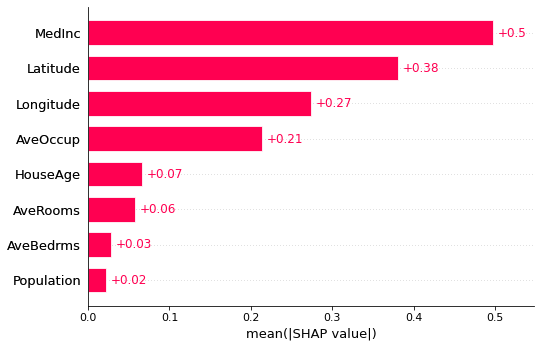

In [24]:
shap.plots.bar(shap_values)

SHAP also makes it possible to obtain information about a single example. In this example, it can be seen that the latitude and longitude have a great influence on the result. It is interesting that they almost neutralise each other. Then you can see that the median income has the greatest influence.

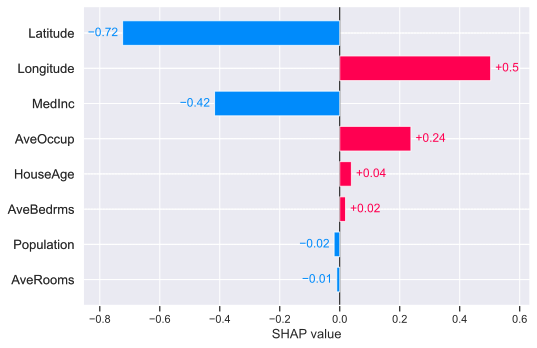

In [54]:
shap.plots.bar(shap_values[1])

For a better understanding you can use the waterfall plot. This shows the predicted value of the house and the correct price. For information, the price expressed in hundreds of thousands of dollars ($100,000). So in this example it means that the estimated value is $165k and the real price is $202k. The reason for the lower valuation is the median income of the owners.

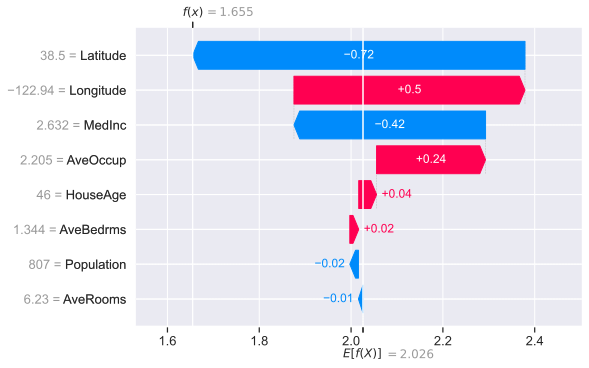

In [61]:
shap.plots.waterfall(shap_values[1])

### Explaining with Local Perturbations <a id='5'></a> 
Another group of techniques builds explanations by examining how the model responds to small-scale variations. This covers approaches based on perturbation and optimization as well as methods that make use of gradient information.
Machine learning has a long history of using explanation techniques that depend on the gradient of the relevant function. The so-called Sensitivity Analysis (SA) is one illustration. SA strictly explains the change in the forecast rather than the prediction itself, despite the fact that it is frequently employed as an explanation approach.
Additionally, it has been demonstrated that SA suffers from basic issues such gradient shattering and explanation discontinuities, and is therefore deemed inadequate for the purpose of explaining current AI models. Sensitivity analysis has several variants that address some of these issues by integrating the gradients along a predetermined path or locally averaging the gradients.
Methods of explanation based on perturbations specifically examine how the model reacts to more widespread local disturbances. While the Prediction Difference Analysis (PDA) methodology of employs conditional sampling within the pixel neighborhood of an investigated feature to efficiently eliminate information, the occlusion method of assesses the relevance of input dimensions by masking portions of the input. Both approaches are model-neutral, i.e., they may be used with any classifier. However, because the function of interest (such as a neural network) must be assessed for all perturbations, they are not very computationally efficient.
Another model-independent strategy for utilizing local perturbations to explain is the meaningful perturbation method. It views explanation as a meta-prediction work and uses optimization to combine the explanations with the most useful information. Other approaches also make advantage of the concept of formulating explanation as an optimization problem. For instance, by creating prototypes that are reflective of the taught notion, the approaches seek to understand what the model has learnt. In the context of activation maximization, these prototypes are calculated by looking for an input pattern that maximizes the intended model response. Conceptually, the meaningful perturbation method and activation maximization are related. Activation maximization finds a minimal perturbation of the gray picture that makes f(x) high, whereas the latter seeks a minimum perturbation of the data that makes f(x) low. These techniques can be quite computationally expensive due to the expenses of optimization. [[1]](#100) <br>

#### Example of Local Perturbations with Adversarial Patches <a id='6'></a> 
The Adversarial Patches are a method that using a small photo and put in the original photo and check if the prediction of class is same like before. To put it another way, we will make a tiny picture patch that conceals a little portion of the original image while secretly causing the model to predict a certain class. In practical applications, this type of attack poses a greater hazard than FSGM. Consider an autonomous vehicle network that gets a real-time picture from a camera. To trick an autonomous vehicle into thinking that an automobile is actually a pedestrian, another driver may print out a certain design and stick it on the rear of his or her vehicle. Humans would not be aware of it in the interim. In 2017, Tom Brown suggested a method for robustly learning such adversarial picture patches and offered a brief example on YouTube. It's interesting to note that the model completely ignores the addition of a little image of the target class (in this case, a toaster) to the original image. However, a specially created patch, which only resembles a toaster, may instantly alter the network's forecast. [[5]](#104) <br>

The following example shows how to create an adversarial patch and how to trick neural networks with it.

The first step is import all libaries.

In [27]:
## Standard libraries
import os
import json
import math
import time
import numpy as np
import scipy.linalg

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial10"


# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cpu


`set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


The next step is the download of the data.

In [28]:
import urllib.request
from urllib.error import HTTPError
import zipfile
# Github URL where the dataset is stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial10/"
# Files to download
pretrained_files = [(DATASET_PATH, "TinyImageNet.zip"), (CHECKPOINT_PATH, "patches.zip")]
# Create checkpoint path if it doesn't exist yet
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for dir_name, file_name in pretrained_files:
    file_path = os.path.join(dir_name, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)
        if file_name.endswith(".zip"):
            print("Unzipping file...")
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                zip_ref.extractall(file_path.rsplit("/",1)[0])

For the image recognation we will use a pre-trained Resnet34 model from pytroch.

In [29]:
# Load CNN architecture pretrained on ImageNet
# os.environ["TORCH_HOME"] = CHECKPOINT_PATH
pretrained_model = models.resnet34(pretrained=True)


# No gradients needed for the network
pretrained_model.eval()
for p in pretrained_model.parameters():
    p.requires_grad = False

The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.


The next step is preprocessing for the image recognation.

In [30]:
# Mean and Std from ImageNet
NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD = np.array([0.229, 0.224, 0.225])
# No resizing and center crop necessary as images are already preprocessed.
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN,
                         std=NORM_STD)
])

# Load dataset and create data loader
imagenet_path = os.path.join(DATASET_PATH, "TinyImageNet/")
assert os.path.isdir(imagenet_path), f"Could not find the ImageNet dataset at expected path \"{imagenet_path}\". " + \
                                     f"Please make sure to have downloaded the ImageNet dataset here, or change the {DATASET_PATH=} variable."
dataset = torchvision.datasets.ImageFolder(root=imagenet_path, transform=plain_transforms)
data_loader = data.DataLoader(dataset, batch_size=32, shuffle=False, drop_last=False, num_workers=8)

# Load label names to interpret the label numbers 0 to 999
with open(os.path.join(imagenet_path, "label_list.json"), "r") as f:
    label_names = json.load(f)

def get_label_index(lab_str):
    assert lab_str in label_names, f"Label \"{lab_str}\" not found. Check the spelling of the class."
    return label_names.index(lab_str)

The eval_model function shows the best 5 predictions with the related confidence score.

In [31]:
def eval_model(dataset_loader, img_func=None):
    tp, tp_5, counter = 0., 0., 0.
    for imgs, labels in tqdm(dataset_loader, desc="Validating..."):
        imgs = imgs.to(device)
        labels = labels.to(device)
        if img_func is not None:
            imgs = img_func(imgs, labels)
        with torch.no_grad():
            preds = pretrained_model(imgs)
        tp += (preds.argmax(dim=-1) == labels).sum()
        tp_5 += (preds.topk(5, dim=-1)[1] == labels[...,None]).any(dim=-1).sum()
        counter += preds.shape[0]
    acc = tp.float().item()/counter
    top5 = tp_5.float().item()/counter
    print(f"Top-1 error: {(100.0 * (1 - acc)):4.2f}%")
    print(f"Top-5 error: {(100.0 * (1 - top5)):4.2f}%")
    return acc, top5

The show prediction function shows the image with their corresponding predictions.

In [32]:
def show_prediction(img, label, pred, K=5, adv_img=None, noise=None):

    if isinstance(img, torch.Tensor):
        # Tensor image to numpy
        img = img.cpu().permute(1, 2, 0).numpy()
        img = (img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        img = np.clip(img, a_min=0.0, a_max=1.0)
        label = label.item()

    # Plot on the left the image with the true label as title.
    # On the right, have a horizontal bar plot with the top k predictions including probabilities
    if noise is None or adv_img is None:
        fig, ax = plt.subplots(1, 2, figsize=(10,2), gridspec_kw={'width_ratios': [1, 1]})
    else:
        fig, ax = plt.subplots(1, 5, figsize=(12,2), gridspec_kw={'width_ratios': [1, 1, 1, 1, 2]})

    ax[0].imshow(img)
    ax[0].set_title(label_names[label])
    ax[0].axis('off')

    if adv_img is not None and noise is not None:
        # Visualize adversarial images
        adv_img = adv_img.cpu().permute(1, 2, 0).numpy()
        adv_img = (adv_img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        adv_img = np.clip(adv_img, a_min=0.0, a_max=1.0)
        ax[1].imshow(adv_img)
        ax[1].set_title('Adversarial')
        ax[1].axis('off')
        # Visualize noise
        noise = noise.cpu().permute(1, 2, 0).numpy()
        noise = noise * 0.5 + 0.5 # Scale between 0 to 1
        ax[2].imshow(noise)
        ax[2].set_title('Noise')
        ax[2].axis('off')
        # buffer
        ax[3].axis('off')

    if abs(pred.sum().item() - 1.0) > 1e-4:
        pred = torch.softmax(pred, dim=-1)
    topk_vals, topk_idx = pred.topk(K, dim=-1)
    topk_vals, topk_idx = topk_vals.cpu().numpy(), topk_idx.cpu().numpy()
    ax[-1].barh(np.arange(K), topk_vals*100.0, align='center', color=["C0" if topk_idx[i]!=label else "C2" for i in range(K)])
    ax[-1].set_yticks(np.arange(K))
    ax[-1].set_yticklabels([label_names[c] for c in topk_idx])
    ax[-1].invert_yaxis()
    ax[-1].set_xlabel('Confidence')
    ax[-1].set_title('Predictions')

    plt.show()
    plt.close()

The example photo that we use are different kinds of fishs. The predictions of them are all really high.

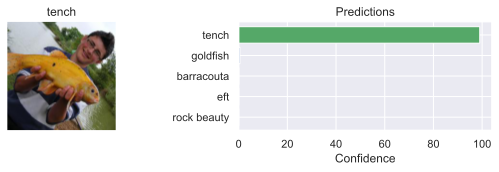

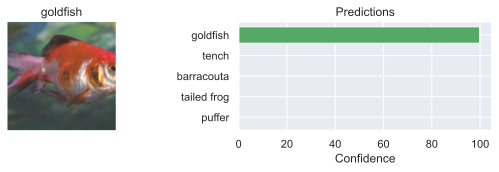

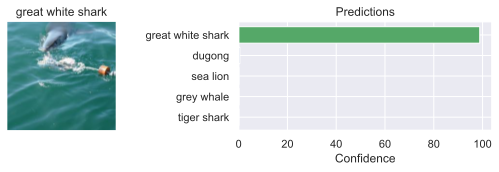

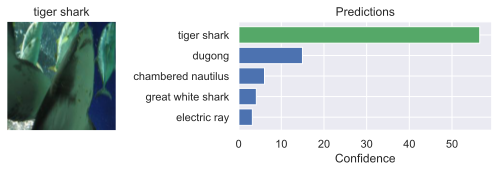

In [33]:
exmp_batch, label_batch = next(iter(data_loader))
with torch.no_grad():
    preds = pretrained_model(exmp_batch.to(device))
for i in range(1,17,5):
    show_prediction(exmp_batch[i], label_batch[i], preds[i])

The next steps are to indroduce stickers that we can put on this fish pictures to trick the neural network.

In [34]:
def place_patch(img, patch):
    for i in range(img.shape[0]):
        h_offset = np.random.randint(0,img.shape[2]-patch.shape[1]-1)
        w_offset = np.random.randint(0,img.shape[3]-patch.shape[2]-1)
        img[i,:,h_offset:h_offset+patch.shape[1],w_offset:w_offset+patch.shape[2]] = patch_forward(patch)
    return img

In [35]:
TENSOR_MEANS, TENSOR_STD = torch.FloatTensor(NORM_MEAN)[:,None,None], torch.FloatTensor(NORM_STD)[:,None,None]
def patch_forward(patch):
    # Map patch values from [-infty,infty] to ImageNet min and max
    patch = (torch.tanh(patch) + 1 - 2 * TENSOR_MEANS) / (2 * TENSOR_STD)
    return patch

In [36]:
def eval_patch(model, patch, val_loader, target_class):
    model.eval()
    tp, tp_5, counter = 0., 0., 0.
    with torch.no_grad():
        for img, img_labels in tqdm(val_loader, desc="Validating...", leave=False):
            # For stability, place the patch at 4 random locations per image, and average the performance
            for _ in range(4):
                patch_img = place_patch(img, patch)
                patch_img = patch_img.to(device)
                img_labels = img_labels.to(device)
                pred = model(patch_img)
                # In the accuracy calculation, we need to exclude the images that are of our target class
                # as we would not "fool" the model into predicting those
                tp += torch.logical_and(pred.argmax(dim=-1) == target_class, img_labels != target_class).sum()
                tp_5 += torch.logical_and((pred.topk(5, dim=-1)[1] == target_class).any(dim=-1), img_labels != target_class).sum()
                counter += (img_labels != target_class).sum()
    acc = tp/counter
    top5 = tp_5/counter
    return acc, top5

In [37]:
def patch_attack(model, target_class, patch_size=64, num_epochs=5):
    # Leave a small set of images out to check generalization
    # In most of our experiments, the performance on the hold-out data points
    # was as good as on the training set. Overfitting was little possible due
    # to the small size of the patches.
    train_set, val_set = torch.utils.data.random_split(dataset, [4500, 500])
    train_loader = data.DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True, num_workers=8)
    val_loader = data.DataLoader(val_set, batch_size=32, shuffle=False, drop_last=False, num_workers=4)

    # Create parameter and optimizer
    if not isinstance(patch_size, tuple):
        patch_size = (patch_size, patch_size)
    patch = nn.Parameter(torch.zeros(3, patch_size[0], patch_size[1]), requires_grad=True)
    optimizer = torch.optim.SGD([patch], lr=1e-1, momentum=0.8)
    loss_module = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(num_epochs):
        t = tqdm(train_loader, leave=False)
        for img, _ in t:
            img = place_patch(img, patch)
            img = img.to(device)
            pred = model(img)
            labels = torch.zeros(img.shape[0], device=pred.device, dtype=torch.long).fill_(target_class)
            loss = loss_module(pred, labels)
            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()
            t.set_description(f"Epoch {epoch}, Loss: {loss.item():4.2f}")

    # Final validation
    acc, top5 = eval_patch(model, patch, val_loader, target_class)

    return patch.data, {"acc": acc.item(), "top5": top5.item()}

In [38]:
# Load evaluation results of the pretrained patches
json_results_file = os.path.join(CHECKPOINT_PATH, "patch_results.json")
json_results = {}
if os.path.isfile(json_results_file):
    with open(json_results_file, "r") as f:
        json_results = json.load(f)

# If you train new patches, you can save the results via calling this function
def save_results(patch_dict):
    result_dict = {cname: {psize: [t.item() if isinstance(t, torch.Tensor) else t
                                   for t in patch_dict[cname][psize]["results"]]
                           for psize in patch_dict[cname]}
                   for cname in patch_dict}
    with open(os.path.join(CHECKPOINT_PATH, "patch_results.json"), "w") as f:
        json.dump(result_dict, f, indent=4)

In [39]:
def get_patches(class_names, patch_sizes):
    result_dict = dict()

    # Loop over all classes and patch sizes
    for name in class_names:
        result_dict[name] = dict()
        for patch_size in patch_sizes:
            c = label_names.index(name)
            file_name = os.path.join(CHECKPOINT_PATH, f"{name}_{patch_size}_patch.pt")
            # Load patch if pretrained file exists, otherwise start training
            if not os.path.isfile(file_name):
                patch, val_results = patch_attack(pretrained_model, target_class=c, patch_size=patch_size, num_epochs=5)
                print(f"Validation results for {name} and {patch_size}:", val_results)
                torch.save(patch, file_name)
            else:
                patch = torch.load(file_name)
            # Load evaluation results if exist, otherwise manually evaluate the patch
            if name in json_results:
                results = json_results[name][str(patch_size)]
            else:
                results = eval_patch(pretrained_model, patch, data_loader, target_class=c)

            # Store results and the patches in a dict for better access
            result_dict[name][patch_size] = {
                "results": results,
                "patch": patch
            }

    return result_dict

In [40]:
class_names = ['toaster', 'goldfish', 'school bus', 'lipstick', 'pineapple']
patch_sizes = [32, 48, 64]

patch_dict = get_patches(class_names, patch_sizes)
# save_results(patch_dict) # Uncomment if you add new class names and want to save the new results

The patches that we use to trick the neural network are a toaster, a goldfish, a schoolbus, a lipstick and a pineapple. Later I'll use only the toaster to deomstrate the attack.

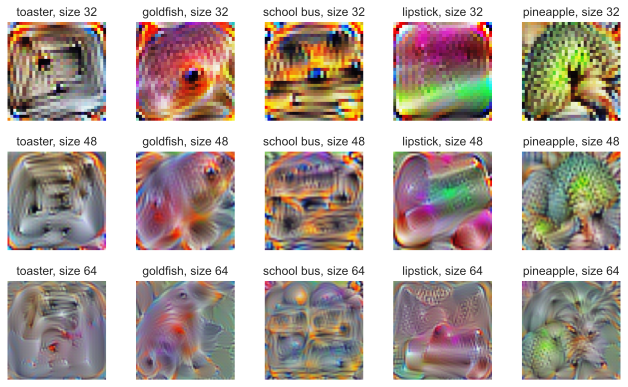

In [41]:
def show_patches():
    fig, ax = plt.subplots(len(patch_sizes), len(class_names), figsize=(len(class_names)*2.2, len(patch_sizes)*2.2))
    for c_idx, cname in enumerate(class_names):
        for p_idx, psize in enumerate(patch_sizes):
            patch = patch_dict[cname][psize]["patch"]
            patch = (torch.tanh(patch) + 1) / 2 # Parameter to pixel values
            patch = patch.cpu().permute(1, 2, 0).numpy()
            patch = np.clip(patch, a_min=0.0, a_max=1.0)
            ax[p_idx][c_idx].imshow(patch)
            ax[p_idx][c_idx].set_title(f"{cname}, size {psize}")
            ax[p_idx][c_idx].axis('off')
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()
show_patches()

In [42]:
def perform_patch_attack(patch):
    patch_batch = exmp_batch.clone()
    patch_batch = place_patch(patch_batch, patch)
    with torch.no_grad():
        patch_preds = pretrained_model(patch_batch.to(device))
    for i in range(1,17,5):
        show_prediction(patch_batch[i], label_batch[i], patch_preds[i])

The next step is the Adversial Attack where toasters are randomly applied to the initial photos. As an example I have taken the middle variant where the sticker is 48x48 pixels. You can see that toaster has the highest confidence in almost all predictions. Only the picture with the goldfish could still predict goldfish correctly. It is frightening that such simple attacks can disrupt a neural network. If you consider that image recognition is already used today to recognise traffic signs, you could paralyse autonomous vehicles. [[7]](#100) <br>

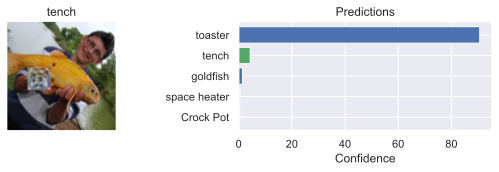

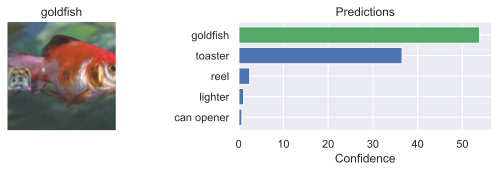

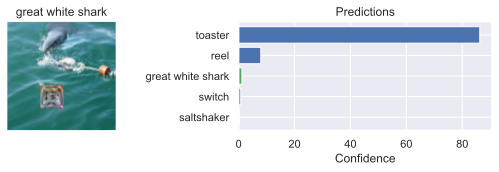

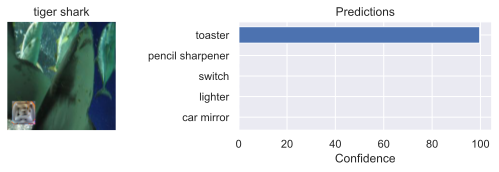

In [43]:
perform_patch_attack(patch_dict['toaster'][48]['patch'])

### Propagation-Based Approaches (Leveraging Structure) <a id='7'></a> 
Deep neural networks, LSTMs, and Fisher Vector classifiers are examples of broad neural network designs that may be used with a propagation-based explanation paradigm known as Layer-wise Relevance Propagation (LRP). LRP can help to explain certain model decisions by using local redistribution rules to convey the prediction from the output to the input. The propagation process may be supported by the deep Taylor decomposition framework. LRP has recently been applied to explain predictions from a wider range of machine learning models, such as clustering or anomaly detection, by first "neuralizing" the model into a neural network. By utilizing the model structure and making use of appropriate (theoretically-motivated) propagation rules, LRP may offer insightful explanations at a very low computational cost (one forward and one backward pass). <br> <br>

#### Example of Propagation-Based Approaches (Leveraging Structure) with Zennit<a id='8'></a> 
The Zennit framework written in Pytroch provides LRP and will be represented next. [[6]](#100) <br>
The goal of Zennit is the same like the first example with Lime. This time, it should also be made explainable why the CNN made the decision. However, the technique of LRP is used. This shows the result as a heatmap. <br> 
In this example, we want to predict why the neural network VGG11 predicts a lighthouse. For this purpose, Zennit will return the pixels that were important for the decision in a heat map.


First step is to load the necessary libaries.

In [44]:
import logging

import torch
from PIL import Image
from torchvision.transforms import Compose, Resize, CenterCrop
from torchvision.transforms import ToTensor, Normalize
from torchvision.models import vgg11_bn

from zennit.attribution import Gradient, SmoothGrad
from zennit.composites import EpsilonPlusFlat, EpsilonGammaBox
from zennit.image import imgify, imsave
from zennit.torchvision import VGGCanonizer

For our lighthouse example, we download an image from Wikipedia.

In [45]:
torch.hub.download_url_to_file(
    'https://upload.wikimedia.org/wikipedia/commons/thumb/8/8b/2006_09_06_180_Leuchtturm.jpg/640px-2006_09_06_181_Leuchtturm.jpg',
    'dornbusch-lighthouse.jpg',
)

100%|██████████| 45.6k/45.6k [00:00<00:00, 574kB/s]


In order for our neural network to process the image, it must be reduced in size. 

In [46]:
# define the base image transform
transform_img = Compose([
    Resize(256),
    CenterCrop(224),
])
# define the full tensor transform
transform = Compose([
    transform_img,
    ToTensor(),
    Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

# load the image
image = Image.open('dornbusch-lighthouse.jpg')

# transform the PIL image and insert a batch-dimension
data = transform(image)[None]

Now we can see the lighthouse in its original size and in the form that the neural network can process.

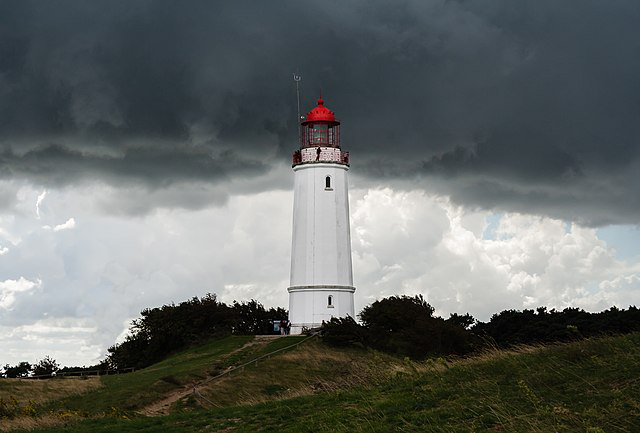

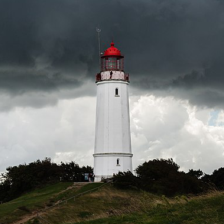

In [47]:
# display the original image
display(image)
# display the resized and cropped image
display(transform_img(image))

For image recognition I use the pre-trained model of VGG11.

In [49]:
# load the model and set it to evaluation mode
model = vgg11_bn(pretrained=True).eval()

The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG11_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_BN_Weights.DEFAULT` to get the most up-to-date weights.
Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /Users/tom.wuesten/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth
100%|██████████| 507M/507M [01:17<00:00, 6.83MB/s] 


In the next step, we apply LRP's method using Zennit to identify the pixels that have the greatest influence on the decision. In addition, the image recognition is predictive. The result of the image recognition is 437 which means lighthouse.

In [50]:
# use the VGG-specific canonizer (alias for SequentialMergeBatchNorm, only
# needed with batch-norm)
canonizer = VGGCanonizer()

# create a composite, specifying the canonizers, if any
composite = EpsilonPlusFlat(canonizers=[canonizer])

# choose a target class for the attribution (label 437 is lighthouse)
target = torch.eye(1000)[[437]]

# create the attributor, specifying model and composite
with Gradient(model=model, composite=composite) as attributor:
    # compute the model output and attribution
    output, attribution = attributor(data, target)

print(f'Prediction: {output.argmax(1)[0].item()}')

Prediction: 437


The final step is to merge the found pixels from Zennit to create a heat map. The resulting heat map is shown below. You can see very well that the contour of the lighthouse has been recognised.

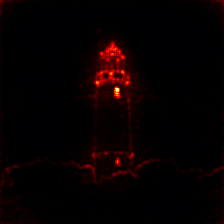

In [51]:
# sum over the channels
relevance = attribution.sum(1)

# create an image of the visualize attribution
img = imgify(relevance, symmetric=True, cmap='coldnhot')

# show the image
display(img)

### Evaluation and Challenges <a id='10'></a> 

This report should have given an insight into the methods that exist to make AI explainable. Not all methods could be discussed, so image recognition in particular was included, because explainability plays a special role in autonomous driving or in medicine sector. <br>
It could be shown with the help of LIME which pixels have the influence on the result. The same effect could be achieved with the help of heat maps. In addition, with the help of local perturbations, it was possible to check how strongly stickers can influence the result. In the example shown, a small toaster sticker was used to trick the image recognition. Such techniques help researchers at image recognation to build better and safer software, especially for auotnomae driving. <br>
Although there has been substantial advancement in the subject of explainable AI in recent years, there are still issues with techniques, theory, and the practical application of explanations. Some of these issues are already the subject of research, such as the objective assessment of explanation quality or the usage of explanations that go beyond visualization. <br>
We can learn more about how the AI model works by using explanation approaches. These techniques still have a number of drawbacks, though. First, heatmaps produced using the explanatory techniques used today depict "first-order" data, or the input features that have been determined to be important for the prediction. The relationship between these qualities, such as whether they are significant on their own or just when present together, is yet unknown. <br>
The explanations' low degree of abstraction is another drawback. Without connecting these relevance values to more abstract ideas like the items or the scene depicted in the image, heatmaps demonstrate which pixels are significant. To make sense of the explanations and comprehend the behavior of the model, humans must interpret them. This interpretation stage may be challenging and inaccurate. <br>
The current state of XAI assessment research shows that the area is still developing and that XAI methodologies should be carefully created and selected. According to user surveys, conventional explanation maps may not be sufficient to support decision-making. The correct usage of XAI in mission-critical applications may be hampered by human bias in perceiving visual explanations.
The landscape of XAI assessments has recently seen promising advancements as a result of human-grounded evaluations.


### References <a id='13'></a> 
[1]<a id='100'></a>  Samek, Wojciech, and Klaus-Robert Müller. "Towards explainable artificial intelligence." Explainable AI: interpreting, explaining and visualizing deep learning. Springer, Cham, 2019. 5-22. <br>
[2]<a id='101'></a> Wojciech Samek: Meta-Explanations, Interpretable Clustering & Other Recent Developments <br>
[3]<a id='102'></a> Molnar, C. (2022). Interpretable Machine Learning: A Guide for Making Black Box Models Explainable (2nd ed.). christophm.github.io/interpretable-ml-book/ <br>
[4]<a id='103'></a> Example SHAP https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137 <br>
[5]<a id='104'></a> Example Adversarial Patches https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial10/Adversarial_Attacks.html <br>
[6]<a id='105'></a> Example Zennit @article{anders2021software,
      author  = {Anders, Christopher J. and
                 Neumann, David and
                 Samek, Wojciech and
                 Müller, Klaus-Robert and
                 Lapuschkin, Sebastian},
      title   = {Software for Dataset-wide XAI: From Local Explanations to Global Insights with {Zennit}, {CoRelAy}, and {ViRelAy}},
      journal = {CoRR},
      volume  = {abs/2106.13200},
      year    = {2021},
} https://github.com/chr5tphr/zennit <br>
[7]<a id='106'></a> @article{DBLP:journals/corr/abs-1711-05611,
  author    = {Bolei Zhou and
               David Bau and
               Aude Oliva and
               Antonio Torralba},
  title     = {Interpreting Deep Visual Representations via Network Dissection},
  journal   = {CoRR},
  volume    = {abs/1711.05611},
  year      = {2017},
  url       = {http://arxiv.org/abs/1711.05611},
  eprinttype = {arXiv},
  eprint    = {1711.05611},
  timestamp = {Mon, 13 Aug 2018 16:47:48 +0200},
  biburl    = {https://dblp.org/rec/journals/corr/abs-1711-05611.bib},
  bibsource = {dblp computer science bibliography, https://dblp.org}
} <br>
[7]<a id='106'></a> https://www.heise.de/hintergrund/Pixelmuster-irritieren-die-KI-autonomer-Fahrzeuge-4852995.html
